<a href="https://colab.research.google.com/github/jcdiaz2/Hito-1/blob/master/Hito_2_Juan_Carlos_D%C3%ADaz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Juan Carlos Díaz

# Conectar con la api
Primero se muesta como conecta para obtener los valores reales, que posteriormente se utilizarán en los modelos


In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import numpy as np
from scipy.stats import norm
import datetime

# Símbolo del Banco de Chile en Yahoo Finance
symbol = 'BCH'

# Obtener datos históricos desde Yahoo Finance
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Obtener el precio actual
current_price = stock_data['Adj Close'][-1]
print(f"El precio de actual de una acción del Banco de Chile es: {current_price}")


#obtener la fecha de vencimiento
from datetime import datetime

fecha_actual = datetime.now()
fecha_vencimiento = datetime(2023, 12, 31)  # Cambiar a fecha necesaria

diferencia = fecha_vencimiento - fecha_actual # Calcular la diferencia entre las fechas

dias_hasta_vencimiento = diferencia.days
semanas_hasta_vencimiento = dias_hasta_vencimiento / 7.0
meses_hasta_vencimiento = dias_hasta_vencimiento / 30.44  # Asumiendo un promedio de días por mes
años_hasta_vencimiento = dias_hasta_vencimiento /252

print(f'Tiempo hasta el vencimiento: {años_hasta_vencimiento} días')

# Para la desviación estandar, volatilidad

historical_data = yf.download(symbol, start=start_date, end=end_date) #datos historicos

historical_data['Daily Returns'] = historical_data['Adj Close'].pct_change()# Calcular rendimientos diarios

# Calcular la volatilidad histórica
volatility = np.std(historical_data['Daily Returns']) * np.sqrt(252)  # Se asume 252 días hábiles en un año

print(f'Volatilidad histórica del Banco de Chile: {volatility:.4f}')

#Para la tasa de interes libre de riesgo

symbol_bono = "^TNX" ##'^CHILE10Y' #ver bien el del gob de Chile, se usa este otro como similar

historical_data_bono = yf.download(symbol_bono, start=start_date, end=end_date)# Obtener datos históricos del bono del gobierno desde Yahoo Finance

historical_data_bono['Daily Returns'] = historical_data_bono['Adj Close'].pct_change()# Calcular rendimientos diarios

tasa_libre_riesgo = np.mean(historical_data_bono['Daily Returns']) * 252  # Asumiendo 252 días hábiles en un año

print(f'Tasa de interés libre de riesgo compuesta continuamente: {tasa_libre_riesgo:.4f}')

#para el calculo del S0

data = yf.Ticker(symbol)
S0 = data.history(period="1d")["Close"].iloc[-1]

print(f"El S0 será:{S0}")


[*********************100%%**********************]  1 of 1 completed
El precio de actual de una acción del Banco de Chile es: 18.707515716552734
Tiempo hasta el vencimiento: 0.25793650793650796 días
[*********************100%%**********************]  1 of 1 completed
Volatilidad histórica del Banco de Chile: 0.3291
[*********************100%%**********************]  1 of 1 completed
Tasa de interés libre de riesgo compuesta continuamente: 0.9721
El S0 será:19.530000686645508


# Valoración opciones aplicada

Tome en consideración el modelo continuio de Black and Scholes:

$$C(S,t)=S\cdot\Phi(d_1)-K\exp(-R\cdot t)\cdot\Phi(d_2)$$

donde $d_1=\frac{\log\frac{S}{K}+\left(R+\frac{\sigma^2}{2}\right)\cdot t}{\sqrt{\sigma^2\cdot t}}$ y $d_2=d_1-\sqrt{\sigma^2\cdot t}$.

Mediante los datos actuales descargados anteriormente, se tiene lo siguiente.

In [ ]:
import numpy as np
from scipy.stats import norm

def black_scholes_option_price(S, K, T, r, sigma, option_type='call'):
    """
    Calcula el precio de una opción utilizando el modelo de Black-Scholes.

    Parámetros:
    S : Precio actual del activo subyacente (por ejemplo, precio de la acción).
    K : Precio de ejercicio de la opción.
    T : Tiempo hasta la expiración en años.
    r : Tasa libre de riesgo.
    sigma : Volatilidad del activo subyacente.
    option_type : 'call' para una opción de compra, 'put' para una opción de venta.

    Retorna:
    El precio teórico de la opción.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type debe ser 'call' o 'put'.")

    return option_price

# Datos para el cálculo
#S0=S0  # Precio actual del Banco de Chile
K = current_price  # Precio de ejercicio de la opción
T = años_hasta_vencimiento  # Tiempo hasta la expiración en años
r = tasa_libre_riesgo # Tasa libre de riesgo
sigma = volatility  # Volatilidad del activo

# Calcular el precio de una opción de compra
call_option_price = black_scholes_option_price(S0, K, T, r, sigma, option_type='call')
print(f'El precio teórico de la opción de compra es: {call_option_price}')

# Calcular el precio de una opción de venta
put_option_price = black_scholes_option_price(S0, K, T, r, sigma, option_type='put')
print(f'El precio teórico de la opción de venta es: {put_option_price}')


El precio teórico de la opción de compra es: 5.015983214096131
El precio teórico de la opción de venta es: 0.04460042354522198


# Modelo Binominal
Corresponde a un modelo para valorar opciones financieras, al igual que el Black and Scholes. Pero este modelo se basa en la teoría de las opciones reales, se desarrolla en un ambiente neutral al riesgo, por lo que es posible valorar las opciones en flujos de fondos esperados, actualizados y suponiendo que los flujos crecen a tasa libre de riesgo. (El Modelo Binomial, n.d.)

La idea de este modelo esta en que el precio del activo (en este caso la acción), puede subir o bajar en un periodo de tiempo, por lo que es un modelo eficiente para calcular el precio de la opción en cada punto del tiempo.

#Pasos construcción del modelo:

1. Construcción del Árbol Binomial: se observan las posibles trayectorias del precio de la opción en el tiempo, como el clásico árbol en probabilidades, donde cada nodo corresponde al precio y las flechas las probabilidades.

2. Cálculo de Probabilidades: se asignan las probabilidades la cual si el precio aumenta es *p* y si dismunuye será *(1-p)*.

3. Cálculo del Precio de la Opción: se utiliza la fórmula binomial. En donde la opción de compra (*C*) es:
  *C= max(0,S-K)*

  Y para la opción de venta (*P*) es:*P= max(0,K-S)*

  En donde *S* es el precio del activo y *K* es el precio de ejecicio (misma manera de calcular que el modelo Black and Scholes)

4. Descontar a Valor Presente: es necesario que se lleve a valor presente para obtener el valor actual de la opción.

Con lo anterior, la formula para calcular el precio de la opción con el modelo binomial será:






$C = e^{-rT} (pCu + (1-p)Cd) $

En donde todos los terminos han sido mencionado anteriormente, aparece el termino *t*  que corresponde al intervalo de tiempo, además del *r* como la tasa libre de riesgo. El *Cu* que es el precio cuando la acción sube y el *Cd* que es cuando baja.

In [ ]:
import numpy as np

def binomial_option_pricing(S, K, T, r, sigma, n, option_type='call'):
    """
    Calcula el precio de una opción utilizando el modelo binomial.

    Parámetros:
    S : Precio actual del activo subyacente.
    K : Precio de ejercicio de la opción.
    T : Tiempo hasta la expiración en años.
    r : Tasa libre de riesgo.
    sigma : Volatilidad del activo subyacente.
    n : Número de pasos en el modelo binomial.
    option_type : 'call' para una opción de compra, 'put' para una opción de venta.

    Retorna:
    El precio teórico de la opción.
    """
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    option_prices = np.zeros((n + 1,))

    # Calcular precios de la opción en el último período
    for i in range(n + 1):
        if option_type == 'call':
            option_prices[i] = max(0, S * (u ** i) * (d ** (n - i)) - K)
        elif option_type == 'put':
            option_prices[i] = max(0, K - S * (u ** i) * (d ** (n - i)))

    # Calcular precios en períodos anteriores
    for j in range(n, 0, -1):
        for i in range(j):
            option_prices[i] = np.exp(-r * dt) * (p * option_prices[i + 1] + (1 - p) * option_prices[i])

    return option_prices[0]

# Parámetros para el cálculo
#SO # Precio actual del Banco de Chile
#K # Precio de ejercicio de la opción
#Tiempo hasta la expiración en años
# Tasa libre de riesgo
#sigma =Volatilidad del activo
n = 100  # Número de pasos en el modelo binomial

# Calcular el precio de una opción de compra
call_option_price = binomial_option_pricing(S0, K, T, r, sigma, n, option_type='call')
print(f'El precio teórico de la opción de compra es: {call_option_price}')

El precio teórico de la opción de compra es: 5.01510263832148


# Análisis

Se puede observar que los 2 modelos cumplen la función de calcular el precio de compra o venta de una opción, uno tiene un enfoque más actualizado de los valores como es el binomial y el otro más global.

Tienen similitudes más que nada en terminos de las variables, en ambos se utiliza el S0 (precio actual activo), el K (precio de ejercicio), el r (tasa de interés), sigma (volatilidad del activo) y t (tiempo de expiración). De hecho, dado que las variables son tan similares se es fácil el calculo del binomial, dado que ya se habían obtenido los valores reales con anterioridad.

Dentro de las diferencias, podemos decir que el modelo binomial es más preciso, dado que tiene más pasos e iteraciones que dan un valor muy fiable, siendo preciso dada la cantidad de repeticiones. Por otro lado el Black and Scholes es más sencillo, menos preciso pero más fácil de utilizar.

De acuerdo a los valores el Black and Scholes entrega un 5,0159 y el Binomial un 5,0151. Se puede ver que son valores bastante similares y en realidad no hay una razón de fondo a elegir uno sobre otro observando solamente estos valores. Por otro lado, es importante mencionar que si se aumentan las repeticiones del Binomial ya dependería de si el computador pueda o no.

Por eso, no hay un argumento fuerte en cual es mejor, más que nada ver si se necesita una mayor presición o no.

# Trabajo Grupal

Para esta parte, se desarrollo el caso de Braam Industries, que se encuentra en la página 874 del ROSS, la cual trata de administración de efectivo.
Los resultados a las preguntas del caso, se muestran en la siguiente foto:

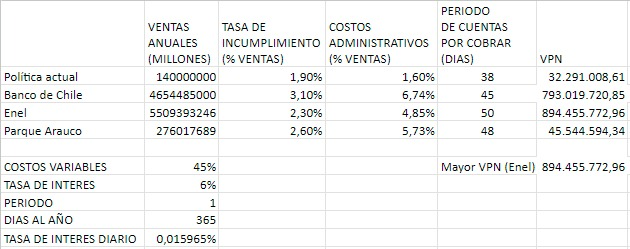

Primero se deben poner las 3 opciones, las cuales fueron elegidas en el hito 1, son Banco de Chile, Enel y Parque Arauco.

La primera pregunta a responder es, Ventas Anuales, que corresponde a las ventas dentro de un año de cada activo en millones de dolares, donde Enel tuvo la mayor venta anual. Luego se desarrolla la Tasa de Incumplimiento, la cual se calcula sacando el porcentaje de prestamos en morosidad (que aún no se pagan) respecto al total de ventas anuales por cada opcion, donde la mayor tasa es del Banco de Chile, lo cual hace sentido al ser un banco.

Luego se calculan los Costos Administrativos, en donde se calcula sacando el porcentaje de gastos de administracion respecto al total de ventas anuales por cada opcion, donde el mayor porcentaje de gasto administrativo lo tiene Banco de Chile.

Para la resolver el Periodo de Cuentas por Cobrar, se utilizo una proporcion similar a la expuesta en el libro.

Por último, se obtiene el calculo de VPN para cada opción, esto mediante el calculo de Excel, donde el mayor VPN lo tiene ENEL luego Banco de Chile y por ultimo Parque arauco. Por lo tanto escojemos la opcion ENEL debido que tiene el mayor VPN, y será la mejor política para la empresa.





# Referencias:

El modelo binomial. (n.d.). oikonomicon. Retrieved October 26, 2023, from https://oikonomicon.udc.es/el_modelo_binomial.html

(n.d.). CAPITULO IV. MODELO BINOMIAL. Retrieved October 26, 2023, from http://catarina.udlap.mx/u_dl_a/tales/documentos/lat/chanona_r_ma/capitulo4.pdf